A PyTorch linear regression example with the Ames Housing Dataset. This notebook is based on this one: https://www.kaggle.com/code/nadzmiagthomas/pytorch-regression

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # visualizing missing values

import torch 
import torch.nn as nn # For neural network building
import torch.nn.functional as F # For activation function
from torch.utils import data  # For data handling
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler # Same as previous
from sklearn.model_selection import train_test_split # For splitting the data
from sklearn.model_selection import KFold # For kfold training

In [2]:
data_path = "data/Ames_Housing_dataset"
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))
print("train:", train.shape)
print("test:", test.shape)

train: (1460, 81)
test: (1459, 80)


In [3]:
sns.histplot(train['SalePrice'], kde=True)

<Axes: xlabel='SalePrice', ylabel='Count'>

Since the label is positively skewed and the price values are very large, we will use log to scale down the label (a few cells down).

<Axes: >

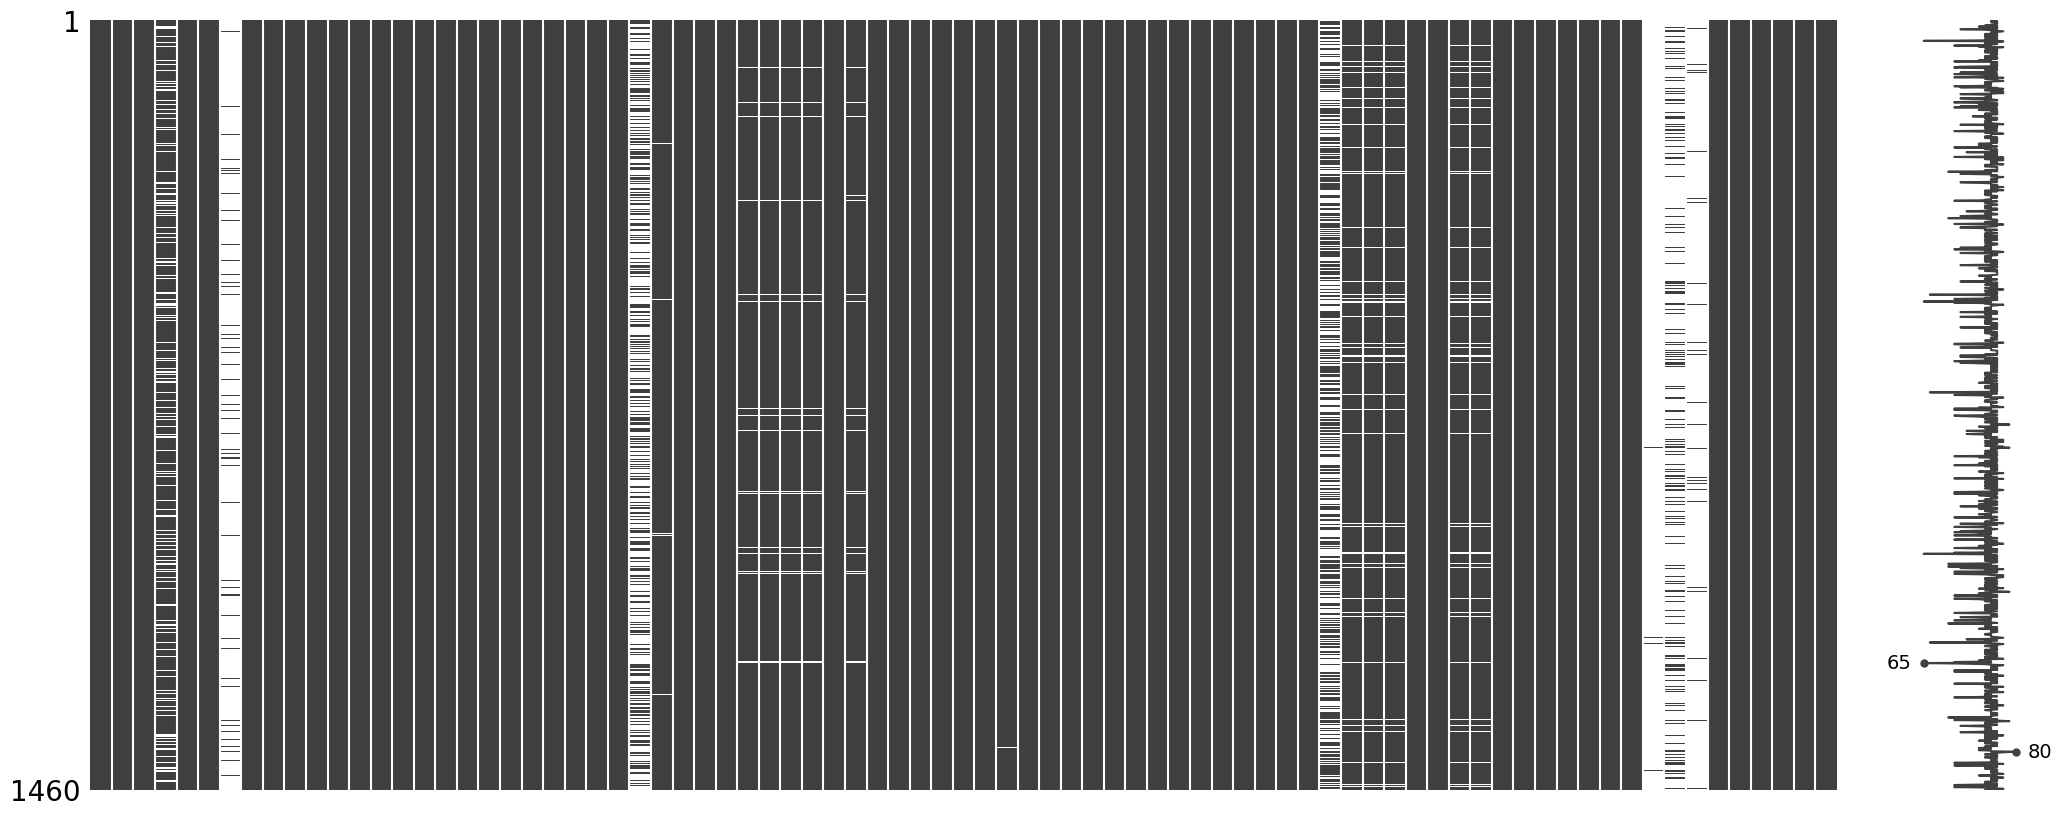

In [4]:
# Visualize missing values
msno.matrix(train)

The white spaces idicate missing values. We will address this by using imputation for quantitative values and by adding a NA column for qualitative values.

In [5]:
# Preprocessing function
def preprocess(df):
    df = df.copy() # Make copy so we don't ruin the original data frame
    df = df.drop(columns=["Id"], errors='ignore') # Drop Id column
    
    numeric_cols = df.select_dtypes(np.number).columns # Numerical column name
    numeric_cols = numeric_cols.drop("SalePrice", errors='ignore') # Drop label
    categorical_cols =  df.select_dtypes(include=['object']).columns # Categorical column name
    
    df_categorical = pd.get_dummies(df[categorical_cols], dummy_na=True) # OneHotEncoding, dummy_na create another column to indicate if the cell contain NA
    
    df_numerical = df[numeric_cols].apply(lambda x: (x - x.mean()) / (x.std())) # Normalize every numerical column
    df_numerical = df_numerical.fillna(0) # Fill in missing value with mean 0
    
    df = pd.concat([df_numerical, df_categorical], axis=1) # Bind numerical column and categorical column
    
    return df

In [6]:
# Get inputs and target
df_train_y = train["SalePrice"].copy() # Copy the target
df_train_y = np.log(df_train_y, where=df_train_y != 0) # Scale the target
df_train_X = preprocess(train) # Preprocess the inputs
print("df_train_X:", df_train_X.shape)
print("df_train_y:", df_train_y.shape)

df_train_X: (1460, 330)
df_train_y: (1460,)


In [7]:
df_train_X.head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073350    -0.207948 -0.207071     0.651256    -0.517023   1.050634   
1   -0.872264     0.409724 -0.091855    -0.071812     2.178881   0.156680   
2    0.073350    -0.084413  0.073455     0.651256    -0.517023   0.984415   
3    0.309753    -0.413838 -0.096864     0.651256    -0.517023  -1.862993   
4    0.073350     0.574436  0.375020     1.374324    -0.517023   0.951306   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_Oth  \
0      0.878367    0.509840    0.575228   -0.288554  ...         False   
1     -0.429430   -0.572637    1.171591   -0.288554  ...         False   
2      0.829930    0.322063    0.092875   -0.288554  ...         False   
3     -0.720051   -0.572637   -0.499103   -0.288554  ...         False   
4      0.733056    1.360357    0.463410   -0.288554  ...         False   

   SaleType_WD  SaleType_nan  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0         True         False                  False                  False   
1         True         False                  False                  False   
2         True         False                  False                  False   
3         True         False                   True                  False   
4         True         False                  False                  False   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                 False                 False                  True   
1                 False                 False                  True   
2                 False                 False                  True   
3                 False                 False                 False   
4                 False                 False                  True   

   SaleCondition_Partial  SaleCondition_nan  
0                  False              False  
1                  False              False  
2                  False              False  
3                  False              False  
4                  False              False  

[5 rows x 330 columns]

In [8]:
# Now check again the distribution of the data
sns.histplot(df_train_y, kde=True)

<Axes: xlabel='SalePrice', ylabel='Count'>

In [9]:
# Split the data into 80% training and 20% validation
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_train_X, df_train_y, train_size=0.8, random_state=73)
print("df_train_X:", df_train_X.shape)
print("df_train_y:", df_train_y.shape)
print("df_val_X:", df_val_X.shape)
print("df_val_y:", df_val_y.shape)

#from other notebook:
#df_train_X: (934, 331)
#df_train_y: (934,)
#df_val_X: (234, 331)
#df_val_y: (234,)

df_train_X: (1168, 330)
df_train_y: (1168,)
df_val_X: (292, 330)
df_val_y: (292,)


### Build the Model

In [19]:
class Model(nn.Module):
    def __init__(self, D_in=330, H=222, D_out=1, Hn=4):
        super().__init__()
        activation = nn.Softplus() # Activation function
        self.layers = nn.ModuleList([nn.Linear(D_in, H), activation]) # First hidden layer
        for i in range(Hn - 1):
            self.layers.extend([nn.Linear(H, H), activation]) # Add hidden layer
        self.layers.append(nn.Linear(H, D_out)) # Output layer
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Train the model

In [11]:
# Setting seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
set_seed(73)

In [12]:
## Set device to gpu (cuda) if it's available
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)
device = "cpu"

In [13]:
# Data for validation
y_val = torch.tensor(df_val_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_val = torch.tensor(df_val_X.values.astype(np.float32)).float().to(device)

# Prepare data for batch training
y_train = torch.tensor(df_train_y.values).float().to(device).unsqueeze(1) # Unsqueeze to match the shape of the output of our model
X_train = torch.tensor(df_train_X.values.astype(np.float32)).float().to(device)
dataset = TensorDataset(X_train, y_train) # Make X,y into dataset so we can work with DataLoader which iterate our data in batch size
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define Model,Optimizer, Criterion
model = Model().to(device) # Define model and send to gpu
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001) # What approach we use to minimize the gradient
criterion = nn.MSELoss() # Our loss function

In [14]:
train_losses = [] # Store the training loss
val_losses = [] # Store the validation loss
epochs = 50 # Number of time we go over the whole dataset

for epoch in range(epochs):
    if epoch % 10 == 0:
        print("epoch:", epoch)
    running_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        # Forward propagation
        y_pred = model(X) # Make prediction by passing X to our model
        loss = criterion(y_pred, y) # Calculate loss 
        running_loss += loss.item() # Add loss to running loss
        
        # Backward propagation
        optimizer.zero_grad() # Empty the gradient (look up this function)
        loss.backward() # Do backward propagation and calculate the gradient of loss with respect to every parameters (that require gradient)
        optimizer.step() # Adjust parameters to minimize loss
    
    # Append train loss
    train_losses.append(running_loss/(batch + 1)) # Add the average loss of this iteration to training loss
    
    # Check test loss
    y_pred = model(X_val)
    val_loss = criterion(y_pred, y_val).item()
    val_losses.append(val_loss)

epoch: 0
epoch: 10
epoch: 20
epoch: 30
epoch: 40


### Evaluate the Model

In [15]:
print(train_losses[0:50])

[6.594883738111143, 0.0601973095015712, 0.033162233521779105, 0.026920097452677684, 0.02932414284920039, 0.02380786720688825, 0.02325325400555787, 0.02239671644231636, 0.022174023397981305, 0.021007367575617684, 0.021704901322365217, 0.02083065790085964, 0.02070272822341282, 0.02253350009503838, 0.01966779718928243, 0.019689472216781075, 0.022211009276112262, 0.019424532023449875, 0.01916531196871951, 0.019051356036981493, 0.01921083960899037, 0.01846376383256116, 0.02008454530971916, 0.017834033278033953, 0.017293076943095825, 0.016690970889662635, 0.017386270399932582, 0.017128514719182905, 0.01762262141102389, 0.018150953990598656, 0.017274380259675114, 0.017112984634578637, 0.01870438912628244, 0.017002829503625222, 0.017792298330938164, 0.017717858438367304, 0.017271503123569572, 0.015401781300618632, 0.015283194176010685, 0.015769700411298913, 0.015287292036801984, 0.015810291005349527, 0.01592102881572018, 0.015545634833508975, 0.01468627173007045, 0.014673939708314121, 0.015140

<Axes: title={'center': 'Training & Validation Loss'}>

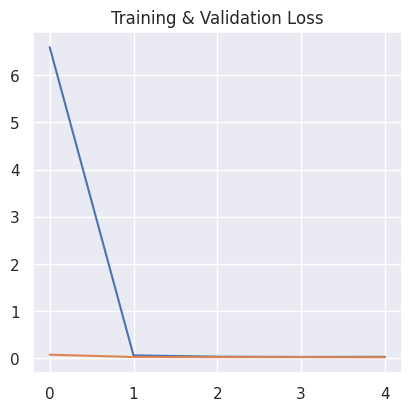

In [16]:
nb_points = 5
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(4,4), constrained_layout=True)
axes.set_title("Training & Validation Loss")
x = [i for i in range(nb_points)]
sns.lineplot(ax=axes, x=x, y=train_losses[0:nb_points])
sns.lineplot(ax=axes, x=x, y=val_losses[0:nb_points])

In [17]:
# Calculate the errors and turn into numpy array
def numpy_error(model, X, y, exp=True):
    y_pred = model(X)
    if exp:
        y = torch.exp(y)
        y_pred = torch.exp(y_pred)
    errors = (y_pred - y).flatten().detach().cpu().numpy()
    return errors

# Calculate the mean absolute error
def mae(errors):
    return np.abs(errors).mean()

# Calculate the root mean squared error
def rmse(errors):
    mse = ((errors)**2).mean()
    return np.sqrt(mse)

In [18]:
# Error on full training set 
errors = numpy_error(model, X_train, y_train, False)
print("Error on training set")
print(f"MAE: {mae(errors)}\nRMSE: {rmse(errors)}")

# Error on testing set
errors = numpy_error(model, X_val, y_val, False)
print("\nError on testing set")
print(f"MAE: {mae(errors)}\nRMSE: {rmse(errors)}")

Error on training set
MAE: 0.08592317998409271
RMSE: 0.1210353896021843

Error on testing set
MAE: 0.08954044431447983
RMSE: 0.12014710158109665
